# **Test technique Mouratoglou - Trampoline park**

***

### Réponse 1 : un même client est inscrit dans plusieurs parcs

>On peut éviter que les clients reçoivent le même email pour chaque parc, nous pourrions choisir le parc avec lequel le client a le plus de fréquentation ou avoir dépensé le plus d'argent et/ou le plus proche de lui. Toutefois, nous pouvons également prendre en compte comme critère additionnel les dates de visites pour savoir les clients les plus actifs ou non actifs et effectuer des segmenation pour répondre au besoins des équipes marketing.
>
>Critères de d'affectation d'un client à un parc :
>
> - Nombre total de visite par parc
>
> - Montant des achats dépensés par parc
>
> - Données de localisation : proximité, ville, région
>

#### 1- Création d'une data random pour illustrer cette proposition : voici le script Python

>J'ai créer 1000 clients aléatoire comme échatillon de test

In [305]:
import faker
import uuid
import pandas as pd

# générer 1000 clients aléatoires
fake = faker.Faker()
clients = []
for i in range(1000):
    clients.append({
        "id": str(uuid.uuid4()),
        "nom": fake.name(),
        "adresse": fake.address(),
        "email": fake.email(),
    })

# générer 10 parcs aléatoires
parcs = []
for i in range(10):
    parcs.append({
        "id": str(uuid.uuid4()),
        "nom": fake.company(),
        "adresse": fake.address(),
        "distance": fake.random_int(min=1, max=100),
    })

# générer des inscriptions aléatoires
inscriptions = []
for client in clients:
    for parc in parcs:
        inscriptions.append({
            "client_id": client["id"],
            "parc_id": parc["id"],
            "date": fake.date_between(start_date="-2y", end_date="today"),
        })

# générer des dépenses aléatoires
depenses = []
for inscription in inscriptions:
    depenses.append({
        "client_id": inscription["client_id"],
        "parc_id": inscription["parc_id"],
        "montant": fake.pyfloat(left_digits=2, right_digits=2, positive=True),
        "date": inscription["date"],
    })

# covertir les listes en DataFrame
clients_df = pd.DataFrame(clients)
parcs_df = pd.DataFrame(parcs)
inscriptions_df = pd.DataFrame(inscriptions)
depenses_df = pd.DataFrame(depenses)

# exporter les données en csv
clients_df.to_csv("clients.csv", index=False)
parcs_df.to_csv("parcs.csv", index=False)
inscriptions_df.to_csv("inscriptions.csv", index=False)
depenses_df.to_csv("depenses.csv", index=False)

#### 1 - Création de la requête SQL qui effectue l'affectation et le filtrage des clients par parc (voir data aléatoire)

In [318]:
import sqlite3
import pandas as pd

# connexion à la base de données
conn = sqlite3.connect('Database.db') 

# création de cursor
cursor = conn.cursor()

# executer la requête
cursor.execute("""
SELECT c.id AS client_id,
       pc.parc_id,
       pc.dépenses AS dépenses_max,
       pc.distance AS distance_min,
       pc.nb_de_visites AS nb_de_visites_max
FROM clients c
JOIN (
    SELECT i.client_id,
           i.parc_id,
           SUM(d.montant) AS dépenses,
           p.distance,
           COUNT(i.parc_id) AS nb_de_visites,
           ROW_NUMBER() OVER (PARTITION BY i.client_id ORDER BY SUM(d.montant) DESC, p.distance ASC, COUNT(i.parc_id) DESC) AS rang
    FROM inscriptions i
    JOIN depenses d ON i.client_id = d.client_id AND i.parc_id = d.parc_id
    JOIN parcs p ON i.parc_id = p.id
    GROUP BY i.client_id, i.parc_id, p.distance
) pc ON c.id = pc.client_id
WHERE pc.rang = 1
ORDER BY pc.dépenses DESC, pc.distance ASC, pc.nb_de_visites DESC;
""")
# cette requête SQL permet de filtrer les clients en fonction des critères séléctionnées (dépenses, nb de visite, localisation)
# Retourner toutes les lignes
rows = cursor.fetchall()

# fermer la connexion
conn.close()

# création d'un DataFrame à partir des résultats
df = pd.DataFrame(rows, columns=['client_id', 'parc_id', 'dépenses_max', 'distance_min', 'nb_de_visites_max'])

# affichage du DataFrame
df.head()

,client_id,parc_id,dépenses_max,distance_min,nb_de_visites_max
0,f843baa7-d3d2-49eb-83f2-e23099682523,134585f4-bc34-4a7e-8fc7-c4ba6af690d7,412.44,71,7
1,924cf61e-171b-40e9-b226-7fe930015008,94719e7e-d522-4315-884d-a38078518594,99.99,11,1
2,81d39272-8c0b-444e-ac0b-66f87e80972e,7cb5aa5e-1b99-47e5-b521-80353359cbe0,99.99,88,1
3,ef97dd08-6a77-40c5-855a-e3ab997ca5f6,6db1f68b-38ae-4011-8403-b13d812316ad,99.98,66,1
4,1b63e336-f537-4731-8aa5-0d6b26fc697e,6db1f68b-38ae-4011-8403-b13d812316ad,99.97,66,1


---

### Réponse 2 : Optimisation des performances

#### 1 - Optimisation des scripts & requêtes SQL

>Pour méliorer la rapidité d'exécution du code je proposes quelques bonnes pratiques pour améliorer le temps d'exécution du code :
> - utiliser une base de données pour stocker les données, ce qui permettra des requêtes plus rapides
> - mettre en place un système de cache pour ne recharger les données que lorsqu'il s'agit des données nouvelles (par exemple en ne rechargeant que les données des 3 derniers mois par rapport à N-1)
> - optimiser les requêtes SQL en utilisant des index aux tables

#### 2- Solution Alternative

>une solution alternative pourrait être de mettre en place un dashboard interactif avec POWER BI. Cela permettrait aux équipes d'avoir une vue consolidée et actualisée des ventes en temps réel, avec des fonctionnalités de filtrage, de comparaison, etc. Les données pourraient être rechargées automatiquement depuis une base de données ou d'autres sources de données qu'on peut connecter à notre ETL.

---

### Réponse 3 : nettoyage des données

#### Nettoyages des emails et numéro de téléphone 

>Pour nettoyer les emails et numéros de téléphone, on pourrait :
>
> - vérifier la validité du format (ex : email avec un @ et un domaine, numéro de téléphone avec le bon nombre de chiffres)
> - supprimer les espaces, caractères spéciaux, etc.
> - appliquer des règles spécifiques (ex : formater les numéros de téléphone dans un format standard)
> - utiliser des librairies de nettoyage de données comme regex 

In [297]:
import re

def nettoyer_email(email):
    # supprimer les espaces et convertir en minuscules
    email = email.strip().lower()
    
    # vérifier le format avec une expression régulière
    if re.match(r'^[\w\.-]+@[\w\.-]+\.\w+$', email):
        return email
    else:
        return None

def nettoyer_telephone(telephone):
    # supprimer les espaces et les caractères non numériques
    telephone = re.sub(r'[^0-9]', '', telephone)
    
    # vérifier la longueur (10 chiffres pour un numéro français)
    if len(telephone) == 10:
        return telephone
    else:
        return None

---

### Réponse 4 : Analyse des kpi's et Data visualisation

#### 1 - Les indicateurs clès pour analyser les réservations

>Pour analyser le comportement des clients en termes de réservation, on pourrait utiliser des indicateurs comme :
> - Le délai moyen entre la réservation et la date d'arrivée
> - Le taux de réservation de dernière minute (ex : moins d'1 semaine avant l'arrivée)
> - Le profil des clients en fonction du délai de réservation (ex : familles réservent plus tôt, jeunes réservent plus tard)
> 
>La moyenne et la médiane peuvent être toutes deux pertinentes selon l'objectif d'analyse :
>  - La moyenne permet d'avoir une vision globale du comportement
>  - La médiane est plus robuste aux valeurs extrêmes et permet d'avoir un indicateur plus représentatif de la tendance centrale

#### 2 - Data visualisation

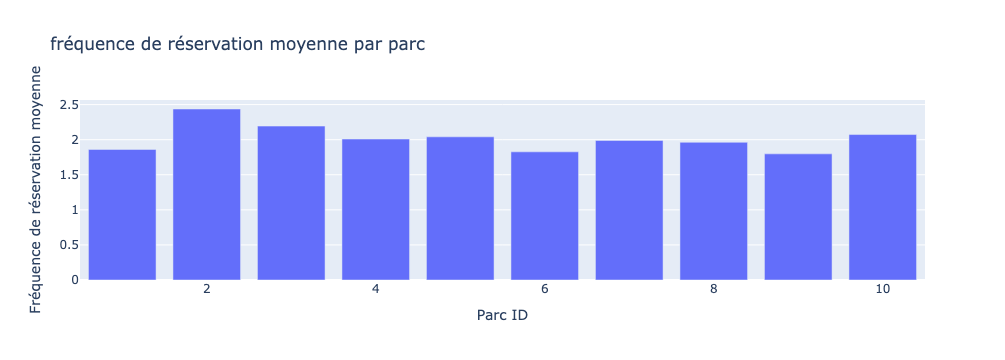

In [466]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# définir une graine aléatoire pour la reproductibilité
np.random.seed(0)

# créer un DataFrame avec 1000 lignes
df = pd.DataFrame({
    'client_id': np.random.choice(range(1, 501), 1000),
    'parc_id': np.random.choice(range(1, 11), 1000),
    'temps_reservation': np.random.normal(loc=30, scale=10, size=1000),
    'frequence_reservation': np.random.poisson(lam=2, size=1000)
})

# s'assurer que temps_reservation est positif
df['temps_reservation'] = df['temps_reservation'].abs()

# arrondir temps_reservation au jour le plus proche
df['temps_reservation'] = df['temps_reservation'].round()

# fréquence de réservation moyenne par parc
fig = px.bar(df.groupby('parc_id')['frequence_reservation'].mean().reset_index(),
             x='parc_id', y='frequence_reservation',
             title='fréquence de réservation moyenne par parc')
fig.update_layout(xaxis_title='Parc ID', yaxis_title='Fréquence de réservation moyenne')
fig.show()

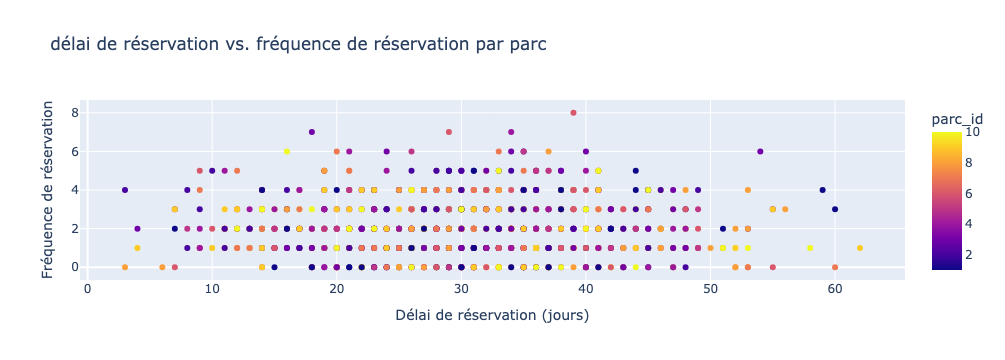

In [468]:
# graphique de dispersion des délais de réservation vs. fréquence de réservation par parc
fig = px.scatter(df, x='temps_reservation', y='frequence_reservation', color='parc_id',
                 title='délai de réservation vs. fréquence de réservation par parc')
fig.update_layout(xaxis_title='Délai de réservation (jours)', yaxis_title='Fréquence de réservation')
fig.show()

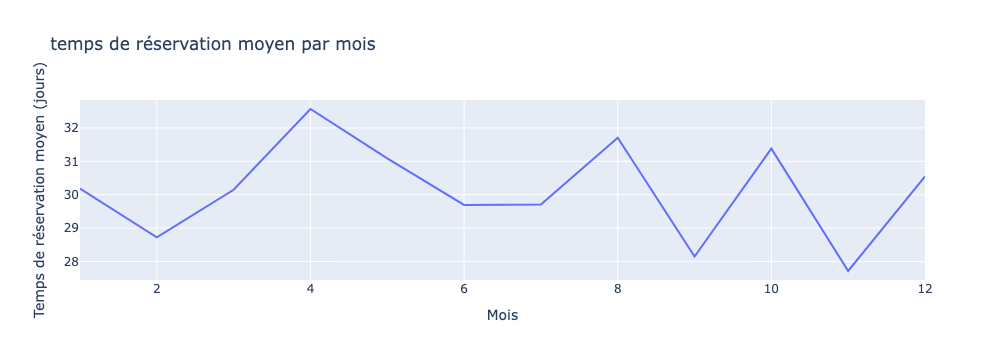

In [470]:
# Ajouter une colonne 'mois' au DataFrame
df['mois'] = np.random.choice(range(1, 13), 1000)

fig = px.line(df.groupby('mois')['temps_reservation'].mean().reset_index(),
              x='mois', y='temps_reservation',
              title='temps de réservation moyen par mois')
fig.update_layout(xaxis_title='Mois', yaxis_title='Temps de réservation moyen (jours)')
fig.show()


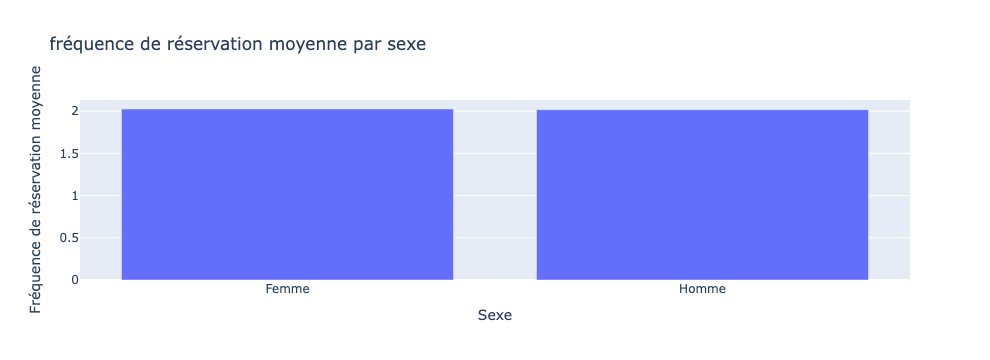

In [476]:
# Ajouter une colonne 'sexe' au DataFrame
df['sexe'] = np.random.choice(['Homme', 'Femme'], 1000)

fig = px.bar(df.groupby('sexe')['frequence_reservation'].mean().reset_index(),
             x='sexe', y='frequence_reservation',
             title='fréquence de réservation moyenne par sexe')
fig.update_layout(xaxis_title='Sexe', yaxis_title='Fréquence de réservation moyenne')
fig.show()


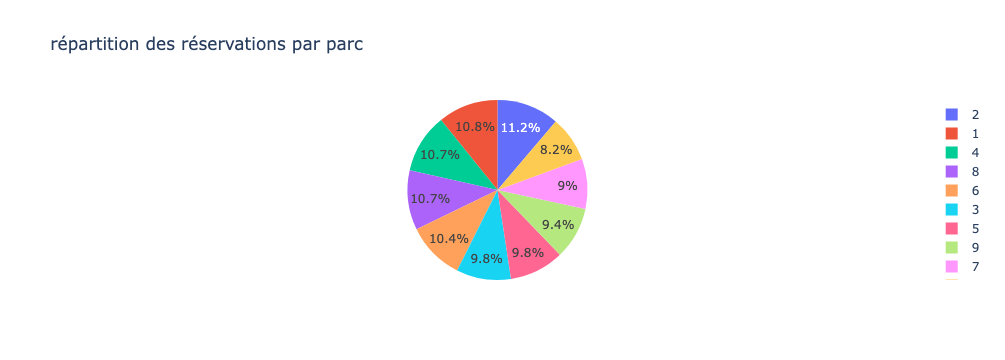

In [474]:
fig = px.pie(df.groupby('parc_id')['client_id'].count().reset_index(),
             values='client_id', names='parc_id',
             title='répartition des réservations par parc')
fig.show()